In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

c:\Users\willy\anaconda3\envs\pytorch_exp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

In [3]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [4]:
# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:37<00:00, 266kB/s]


Extracting C:\Users\willy/.pytorch/MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\willy/.pytorch/MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 96.0kB/s]


Extracting C:\Users\willy/.pytorch/MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\willy/.pytorch/MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:05<00:00, 278kB/s]


Extracting C:\Users\willy/.pytorch/MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\willy/.pytorch/MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.50MB/s]

Extracting C:\Users\willy/.pytorch/MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\willy/.pytorch/MNIST_data/MNIST\raw



60000

In [5]:
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)
len(test_data)

10000

In [6]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [7]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [8]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.

        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [9]:
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 1,149,972


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [10]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [11]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [12]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [13]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  1%|          | 4/469 [00:00<00:41, 11.23it/s]

Step 0 (N samples: 0), Loss: 543.6620 (Recon: 543.4160, KL: 0.2460) Grad: 13.1940


 22%|██▏       | 104/469 [00:05<00:18, 20.13it/s]

Step 100 (N samples: 12,800), Loss: 197.1078 (Recon: 195.3775, KL: 1.7302) Grad: 14.7954


 43%|████▎     | 203/469 [00:10<00:12, 21.46it/s]

Step 200 (N samples: 25,600), Loss: 190.0386 (Recon: 187.9731, KL: 2.0655) Grad: 28.6929


 65%|██████▍   | 303/469 [00:15<00:07, 22.43it/s]

Step 300 (N samples: 38,400), Loss: 185.9014 (Recon: 183.5807, KL: 2.3208) Grad: 28.6925


 86%|████████▌ | 402/469 [00:19<00:03, 22.13it/s]

Step 400 (N samples: 51,200), Loss: 190.9405 (Recon: 188.7255, KL: 2.2150) Grad: 21.4847


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.73it/s]


====> Test set loss: 180.1341 (BCE: 177.2196, KLD: 2.9145)
Epoch 2/50


  7%|▋         | 33/469 [00:01<00:21, 19.95it/s]

Step 500 (N samples: 64,000), Loss: 178.8013 (Recon: 175.9563, KL: 2.8450) Grad: 65.5184


 29%|██▊       | 134/469 [00:06<00:17, 19.60it/s]

Step 600 (N samples: 76,800), Loss: 169.1665 (Recon: 165.1113, KL: 4.0552) Grad: 50.7563


 50%|█████     | 235/469 [00:12<00:11, 20.13it/s]

Step 700 (N samples: 89,600), Loss: 159.4397 (Recon: 154.7010, KL: 4.7387) Grad: 66.8008


 71%|███████   | 333/469 [00:17<00:06, 20.38it/s]

Step 800 (N samples: 102,400), Loss: 166.1472 (Recon: 161.1994, KL: 4.9478) Grad: 43.0112


 93%|█████████▎| 434/469 [00:22<00:01, 17.74it/s]

Step 900 (N samples: 115,200), Loss: 164.0934 (Recon: 159.1096, KL: 4.9837) Grad: 37.9935


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.05it/s]


====> Test set loss: 161.5359 (BCE: 156.5339, KLD: 5.0020)
Epoch 3/50


 14%|█▍        | 67/469 [00:03<00:19, 20.59it/s]

Step 1,000 (N samples: 128,000), Loss: 167.7150 (Recon: 162.7158, KL: 4.9992) Grad: 47.9185


 35%|███▌      | 166/469 [00:08<00:14, 20.84it/s]

Step 1,100 (N samples: 140,800), Loss: 154.4939 (Recon: 149.2547, KL: 5.2392) Grad: 49.6305


 57%|█████▋    | 266/469 [00:13<00:09, 20.58it/s]

Step 1,200 (N samples: 153,600), Loss: 167.1096 (Recon: 161.7422, KL: 5.3674) Grad: 83.7054


 78%|███████▊  | 366/469 [00:18<00:04, 20.79it/s]

Step 1,300 (N samples: 166,400), Loss: 164.7835 (Recon: 159.5622, KL: 5.2213) Grad: 79.5082


100%|█████████▉| 467/469 [00:23<00:00, 19.83it/s]

Step 1,400 (N samples: 179,200), Loss: 153.1218 (Recon: 147.6878, KL: 5.4340) Grad: 50.3864


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.79it/s]


====> Test set loss: 156.7777 (BCE: 151.2820, KLD: 5.4957)
Epoch 4/50


 21%|██        | 97/469 [00:05<00:19, 19.00it/s]

Step 1,500 (N samples: 192,000), Loss: 147.9558 (Recon: 142.6073, KL: 5.3486) Grad: 154.6517


 42%|████▏     | 197/469 [00:10<00:13, 20.36it/s]

Step 1,600 (N samples: 204,800), Loss: 144.5945 (Recon: 138.7962, KL: 5.7983) Grad: 100.9498


 63%|██████▎   | 296/469 [00:15<00:09, 18.98it/s]

Step 1,700 (N samples: 217,600), Loss: 153.0893 (Recon: 147.3812, KL: 5.7080) Grad: 50.2875


 84%|████████▍ | 396/469 [00:21<00:04, 17.73it/s]

Step 1,800 (N samples: 230,400), Loss: 157.0646 (Recon: 151.2876, KL: 5.7769) Grad: 118.7390


Testing: 100%|██████████| 79/79 [00:03<00:00, 22.83it/s]


====> Test set loss: 152.0320 (BCE: 146.4757, KLD: 5.5563)
Epoch 5/50


  6%|▌         | 27/469 [00:01<00:26, 16.56it/s]

Step 1,900 (N samples: 243,200), Loss: 154.7453 (Recon: 149.2445, KL: 5.5008) Grad: 125.4016


 27%|██▋       | 128/469 [00:06<00:16, 21.24it/s]

Step 2,000 (N samples: 256,000), Loss: 156.2590 (Recon: 150.4898, KL: 5.7692) Grad: 52.5146


 49%|████▊     | 228/469 [00:12<00:14, 16.36it/s]

Step 2,100 (N samples: 268,800), Loss: 147.0247 (Recon: 141.2000, KL: 5.8247) Grad: 75.0703


 70%|██████▉   | 327/469 [00:17<00:06, 20.90it/s]

Step 2,200 (N samples: 281,600), Loss: 147.4209 (Recon: 141.4087, KL: 6.0122) Grad: 99.6826


 91%|█████████ | 426/469 [00:21<00:02, 20.42it/s]

Step 2,300 (N samples: 294,400), Loss: 148.9583 (Recon: 143.0700, KL: 5.8883) Grad: 83.3762


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.30it/s]


====> Test set loss: 149.0549 (BCE: 143.2046, KLD: 5.8503)
Epoch 6/50


 12%|█▏        | 58/469 [00:02<00:20, 20.36it/s]

Step 2,400 (N samples: 307,200), Loss: 154.8288 (Recon: 148.9263, KL: 5.9025) Grad: 134.9612


 34%|███▍      | 159/469 [00:07<00:14, 20.85it/s]

Step 2,500 (N samples: 320,000), Loss: 150.7864 (Recon: 144.8235, KL: 5.9629) Grad: 94.6597


 55%|█████▌    | 258/469 [00:13<00:10, 19.54it/s]

Step 2,600 (N samples: 332,800), Loss: 154.6427 (Recon: 148.4765, KL: 6.1662) Grad: 78.2622


 76%|███████▋  | 358/469 [00:18<00:07, 15.16it/s]

Step 2,700 (N samples: 345,600), Loss: 150.5690 (Recon: 144.4679, KL: 6.1012) Grad: 133.4768


 97%|█████████▋| 457/469 [00:24<00:00, 15.55it/s]

Step 2,800 (N samples: 358,400), Loss: 153.4392 (Recon: 147.4814, KL: 5.9578) Grad: 123.7937


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


====> Test set loss: 147.4624 (BCE: 141.5251, KLD: 5.9373)
Epoch 7/50


 19%|█▉        | 90/469 [00:04<00:19, 19.79it/s]

Step 2,900 (N samples: 371,200), Loss: 141.5188 (Recon: 135.4511, KL: 6.0677) Grad: 82.1189


 40%|████      | 189/469 [00:10<00:13, 21.43it/s]

Step 3,000 (N samples: 384,000), Loss: 156.9149 (Recon: 150.9211, KL: 5.9938) Grad: 116.0847


 62%|██████▏   | 289/469 [00:15<00:08, 21.19it/s]

Step 3,100 (N samples: 396,800), Loss: 152.9635 (Recon: 146.8044, KL: 6.1591) Grad: 136.0511


 83%|████████▎ | 388/469 [00:21<00:05, 16.02it/s]

Step 3,200 (N samples: 409,600), Loss: 148.1046 (Recon: 141.8320, KL: 6.2726) Grad: 99.4152


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.70it/s]


====> Test set loss: 146.2368 (BCE: 140.1747, KLD: 6.0621)
Epoch 8/50


  4%|▍         | 20/469 [00:01<00:23, 19.09it/s]

Step 3,300 (N samples: 422,400), Loss: 152.1648 (Recon: 146.1486, KL: 6.0162) Grad: 93.1613


 26%|██▌       | 122/469 [00:05<00:16, 21.22it/s]

Step 3,400 (N samples: 435,200), Loss: 147.1759 (Recon: 141.1750, KL: 6.0009) Grad: 100.9196


 47%|████▋     | 221/469 [00:10<00:11, 21.77it/s]

Step 3,500 (N samples: 448,000), Loss: 145.0795 (Recon: 138.8079, KL: 6.2717) Grad: 260.2911


 68%|██████▊   | 320/469 [00:15<00:08, 17.27it/s]

Step 3,600 (N samples: 460,800), Loss: 142.5536 (Recon: 136.1572, KL: 6.3964) Grad: 79.2823


 90%|████████▉ | 422/469 [00:20<00:02, 20.94it/s]

Step 3,700 (N samples: 473,600), Loss: 141.7868 (Recon: 135.3450, KL: 6.4418) Grad: 104.9694


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.79it/s]


====> Test set loss: 145.5284 (BCE: 139.3042, KLD: 6.2242)
Epoch 9/50


 11%|█▏        | 53/469 [00:02<00:19, 21.46it/s]

Step 3,800 (N samples: 486,400), Loss: 147.2544 (Recon: 141.2351, KL: 6.0192) Grad: 57.1516


 32%|███▏      | 152/469 [00:07<00:16, 19.39it/s]

Step 3,900 (N samples: 499,200), Loss: 149.3168 (Recon: 143.3176, KL: 5.9992) Grad: 109.4153


 54%|█████▎    | 251/469 [00:12<00:12, 17.66it/s]

Step 4,000 (N samples: 512,000), Loss: 150.8079 (Recon: 144.5453, KL: 6.2626) Grad: 167.3852


 75%|███████▌  | 353/469 [00:17<00:05, 21.93it/s]

Step 4,100 (N samples: 524,800), Loss: 152.6307 (Recon: 146.3526, KL: 6.2781) Grad: 107.7729


 96%|█████████▌| 449/469 [00:21<00:00, 21.93it/s]

Step 4,200 (N samples: 537,600), Loss: 145.6120 (Recon: 139.4345, KL: 6.1775) Grad: 89.6726


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.47it/s]


====> Test set loss: 147.8373 (BCE: 141.6837, KLD: 6.1536)
Epoch 10/50


 17%|█▋        | 82/469 [00:04<00:18, 21.41it/s]

Step 4,300 (N samples: 550,400), Loss: 146.0480 (Recon: 139.7961, KL: 6.2519) Grad: 100.9574


 39%|███▉      | 183/469 [00:08<00:13, 21.90it/s]

Step 4,400 (N samples: 563,200), Loss: 149.9430 (Recon: 143.5105, KL: 6.4325) Grad: 184.1757


 60%|██████    | 282/469 [00:13<00:10, 17.77it/s]

Step 4,500 (N samples: 576,000), Loss: 144.0890 (Recon: 137.7035, KL: 6.3855) Grad: 86.8212


 82%|████████▏ | 383/469 [00:18<00:04, 21.00it/s]

Step 4,600 (N samples: 588,800), Loss: 141.8323 (Recon: 135.5195, KL: 6.3128) Grad: 102.5792


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.92it/s]


====> Test set loss: 144.8512 (BCE: 138.5638, KLD: 6.2875)
Epoch 11/50


  3%|▎         | 13/469 [00:00<00:22, 20.27it/s]

Step 4,700 (N samples: 601,600), Loss: 141.1505 (Recon: 134.7534, KL: 6.3971) Grad: 95.2983


 24%|██▍       | 113/469 [00:05<00:17, 19.91it/s]

Step 4,800 (N samples: 614,400), Loss: 147.9020 (Recon: 141.5827, KL: 6.3193) Grad: 140.5836


 46%|████▌     | 215/469 [00:10<00:11, 21.46it/s]

Step 4,900 (N samples: 627,200), Loss: 143.5950 (Recon: 137.3126, KL: 6.2825) Grad: 114.2440


 67%|██████▋   | 314/469 [00:15<00:07, 21.16it/s]

Step 5,000 (N samples: 640,000), Loss: 150.2666 (Recon: 143.9096, KL: 6.3570) Grad: 168.5874


 88%|████████▊ | 413/469 [00:20<00:02, 21.78it/s]

Step 5,100 (N samples: 652,800), Loss: 142.0518 (Recon: 135.7756, KL: 6.2761) Grad: 168.3337


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.08it/s]


====> Test set loss: 143.6374 (BCE: 137.1182, KLD: 6.5191)
Epoch 12/50


 10%|▉         | 46/469 [00:02<00:19, 21.60it/s]

Step 5,200 (N samples: 665,600), Loss: 139.3611 (Recon: 133.0679, KL: 6.2933) Grad: 230.6808


 31%|███       | 145/469 [00:07<00:15, 21.57it/s]

Step 5,300 (N samples: 678,400), Loss: 143.0084 (Recon: 136.6686, KL: 6.3398) Grad: 108.3015


 52%|█████▏    | 243/469 [00:11<00:12, 18.55it/s]

Step 5,400 (N samples: 691,200), Loss: 147.5310 (Recon: 140.8960, KL: 6.6350) Grad: 82.6857


 73%|███████▎  | 344/469 [00:16<00:06, 20.72it/s]

Step 5,500 (N samples: 704,000), Loss: 143.8113 (Recon: 137.4585, KL: 6.3527) Grad: 141.3371


 95%|█████████▍| 445/469 [00:21<00:01, 21.56it/s]

Step 5,600 (N samples: 716,800), Loss: 140.8776 (Recon: 134.3008, KL: 6.5768) Grad: 110.0549


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.21it/s]


====> Test set loss: 144.7025 (BCE: 138.2598, KLD: 6.4427)
Epoch 13/50


 16%|█▌        | 75/469 [00:03<00:20, 19.67it/s]

Step 5,700 (N samples: 729,600), Loss: 143.5693 (Recon: 137.0241, KL: 6.5452) Grad: 135.9089


 38%|███▊      | 176/469 [00:08<00:13, 20.93it/s]

Step 5,800 (N samples: 742,400), Loss: 146.2446 (Recon: 139.8568, KL: 6.3878) Grad: 136.6173


 59%|█████▉    | 277/469 [00:13<00:08, 21.63it/s]

Step 5,900 (N samples: 755,200), Loss: 138.3530 (Recon: 131.7674, KL: 6.5856) Grad: 187.9992


 80%|████████  | 377/469 [00:18<00:04, 21.11it/s]

Step 6,000 (N samples: 768,000), Loss: 138.4222 (Recon: 131.8335, KL: 6.5887) Grad: 116.8461


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.68it/s]


====> Test set loss: 146.0282 (BCE: 139.6808, KLD: 6.3474)
Epoch 14/50


  1%|▏         | 6/469 [00:00<00:21, 21.13it/s]

Step 6,100 (N samples: 780,800), Loss: 143.2254 (Recon: 136.7552, KL: 6.4703) Grad: 148.2077


 23%|██▎       | 108/469 [00:05<00:17, 21.19it/s]

Step 6,200 (N samples: 793,600), Loss: 137.1956 (Recon: 130.8222, KL: 6.3734) Grad: 110.1833


 44%|████▍     | 207/469 [00:10<00:11, 21.85it/s]

Step 6,300 (N samples: 806,400), Loss: 141.4669 (Recon: 134.8280, KL: 6.6389) Grad: 139.2077


 65%|██████▌   | 306/469 [00:15<00:08, 18.87it/s]

Step 6,400 (N samples: 819,200), Loss: 137.2468 (Recon: 130.7861, KL: 6.4607) Grad: 79.7472


 87%|████████▋ | 407/469 [00:20<00:03, 19.40it/s]

Step 6,500 (N samples: 832,000), Loss: 136.5249 (Recon: 129.9181, KL: 6.6069) Grad: 156.3246


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.82it/s]


====> Test set loss: 144.8459 (BCE: 138.2979, KLD: 6.5479)
Epoch 15/50


  8%|▊         | 39/469 [00:01<00:20, 21.19it/s]

Step 6,600 (N samples: 844,800), Loss: 144.1096 (Recon: 137.6961, KL: 6.4135) Grad: 161.3273


 29%|██▉       | 137/469 [00:06<00:15, 22.04it/s]

Step 6,700 (N samples: 857,600), Loss: 147.7098 (Recon: 141.2186, KL: 6.4912) Grad: 120.3914


 51%|█████     | 238/469 [00:11<00:10, 21.92it/s]

Step 6,800 (N samples: 870,400), Loss: 144.0804 (Recon: 137.4811, KL: 6.5993) Grad: 137.6917


 72%|███████▏  | 337/469 [00:16<00:06, 19.85it/s]

Step 6,900 (N samples: 883,200), Loss: 147.7284 (Recon: 141.1628, KL: 6.5656) Grad: 181.4014


 93%|█████████▎| 437/469 [00:20<00:01, 20.34it/s]

Step 7,000 (N samples: 896,000), Loss: 138.4409 (Recon: 131.8997, KL: 6.5411) Grad: 124.5074


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.08it/s]


====> Test set loss: 144.8558 (BCE: 138.2767, KLD: 6.5790)
Epoch 16/50


 14%|█▍        | 68/469 [00:03<00:18, 22.16it/s]

Step 7,100 (N samples: 908,800), Loss: 141.2622 (Recon: 134.6912, KL: 6.5710) Grad: 109.6502


 36%|███▌      | 168/469 [00:07<00:14, 20.61it/s]

Step 7,200 (N samples: 921,600), Loss: 145.9313 (Recon: 139.2963, KL: 6.6350) Grad: 77.8224


 57%|█████▋    | 268/469 [00:12<00:09, 20.70it/s]

Step 7,300 (N samples: 934,400), Loss: 145.7013 (Recon: 139.0900, KL: 6.6114) Grad: 85.4643


 78%|███████▊  | 368/469 [00:18<00:05, 17.50it/s]

Step 7,400 (N samples: 947,200), Loss: 146.2955 (Recon: 139.6053, KL: 6.6902) Grad: 200.6486


100%|██████████| 469/469 [00:23<00:00, 19.58it/s]

Step 7,500 (N samples: 960,000), Loss: 141.0419 (Recon: 134.3997, KL: 6.6422) Grad: 115.2138



Testing: 100%|██████████| 79/79 [00:02<00:00, 26.46it/s]


====> Test set loss: 143.7462 (BCE: 137.1806, KLD: 6.5656)
Epoch 17/50


 21%|██▏       | 100/469 [00:04<00:18, 19.78it/s]

Step 7,600 (N samples: 972,800), Loss: 142.5621 (Recon: 136.1384, KL: 6.4237) Grad: 202.2701


 42%|████▏     | 199/469 [00:09<00:12, 21.42it/s]

Step 7,700 (N samples: 985,600), Loss: 144.7001 (Recon: 138.2334, KL: 6.4666) Grad: 169.4342


 64%|██████▍   | 301/469 [00:14<00:07, 22.06it/s]

Step 7,800 (N samples: 998,400), Loss: 140.0895 (Recon: 133.4121, KL: 6.6774) Grad: 99.5371


 85%|████████▌ | 400/469 [00:18<00:03, 22.43it/s]

Step 7,900 (N samples: 1,011,200), Loss: 135.8743 (Recon: 129.1917, KL: 6.6826) Grad: 131.6760


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.49it/s]


====> Test set loss: 141.8248 (BCE: 135.2438, KLD: 6.5810)
Epoch 18/50


  7%|▋         | 31/469 [00:01<00:21, 20.38it/s]

Step 8,000 (N samples: 1,024,000), Loss: 143.8160 (Recon: 137.4032, KL: 6.4128) Grad: 149.6269


 28%|██▊       | 130/469 [00:06<00:15, 21.35it/s]

Step 8,100 (N samples: 1,036,800), Loss: 140.5139 (Recon: 134.1275, KL: 6.3864) Grad: 90.1248


 49%|████▉     | 231/469 [00:10<00:10, 21.94it/s]

Step 8,200 (N samples: 1,049,600), Loss: 135.6585 (Recon: 128.9754, KL: 6.6831) Grad: 174.6809


 70%|███████   | 330/469 [00:15<00:06, 22.38it/s]

Step 8,300 (N samples: 1,062,400), Loss: 144.0119 (Recon: 137.5031, KL: 6.5088) Grad: 140.5787


 91%|█████████▏| 429/469 [00:20<00:01, 21.55it/s]

Step 8,400 (N samples: 1,075,200), Loss: 148.0957 (Recon: 141.6017, KL: 6.4940) Grad: 116.5523


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.64it/s]


====> Test set loss: 140.8464 (BCE: 134.2537, KLD: 6.5927)
Epoch 19/50


 13%|█▎        | 62/469 [00:02<00:18, 21.90it/s]

Step 8,500 (N samples: 1,088,000), Loss: 145.9092 (Recon: 139.5115, KL: 6.3977) Grad: 317.3966


 35%|███▍      | 163/469 [00:09<00:14, 21.73it/s]

Step 8,600 (N samples: 1,100,800), Loss: 134.5389 (Recon: 127.9566, KL: 6.5823) Grad: 112.1234


 56%|█████▌    | 262/469 [00:13<00:09, 21.94it/s]

Step 8,700 (N samples: 1,113,600), Loss: 144.2443 (Recon: 137.5590, KL: 6.6853) Grad: 137.8273


 77%|███████▋  | 362/469 [00:18<00:05, 21.17it/s]

Step 8,800 (N samples: 1,126,400), Loss: 142.8758 (Recon: 136.3128, KL: 6.5631) Grad: 177.7472


 98%|█████████▊| 461/469 [00:23<00:00, 20.10it/s]

Step 8,900 (N samples: 1,139,200), Loss: 140.7792 (Recon: 134.1450, KL: 6.6343) Grad: 107.7723


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.92it/s]


====> Test set loss: 141.0595 (BCE: 134.4475, KLD: 6.6120)
Epoch 20/50


 20%|██        | 94/469 [00:04<00:17, 21.76it/s]

Step 9,000 (N samples: 1,152,000), Loss: 145.9718 (Recon: 139.2917, KL: 6.6801) Grad: 110.0272


 41%|████      | 193/469 [00:09<00:16, 16.69it/s]

Step 9,100 (N samples: 1,164,800), Loss: 137.5976 (Recon: 130.9485, KL: 6.6491) Grad: 96.0043


 62%|██████▏   | 292/469 [00:15<00:10, 17.50it/s]

Step 9,200 (N samples: 1,177,600), Loss: 146.3743 (Recon: 139.7544, KL: 6.6199) Grad: 152.6907


 84%|████████▍ | 393/469 [00:21<00:03, 20.28it/s]

Step 9,300 (N samples: 1,190,400), Loss: 144.1343 (Recon: 137.4911, KL: 6.6432) Grad: 149.3141


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.02it/s]


====> Test set loss: 142.6500 (BCE: 135.8493, KLD: 6.8007)
Epoch 21/50


  5%|▍         | 23/469 [00:01<00:37, 11.88it/s]

Step 9,400 (N samples: 1,203,200), Loss: 148.2024 (Recon: 141.5577, KL: 6.6447) Grad: 182.3107


 27%|██▋       | 125/469 [00:06<00:17, 19.62it/s]

Step 9,500 (N samples: 1,216,000), Loss: 138.7128 (Recon: 132.0506, KL: 6.6623) Grad: 83.3103


 48%|████▊     | 224/469 [00:11<00:14, 16.44it/s]

Step 9,600 (N samples: 1,228,800), Loss: 141.8420 (Recon: 134.9667, KL: 6.8753) Grad: 101.3718


 69%|██████▉   | 324/469 [00:17<00:10, 14.40it/s]

Step 9,700 (N samples: 1,241,600), Loss: 154.8602 (Recon: 148.2120, KL: 6.6481) Grad: 234.9438


 90%|████████▉ | 422/469 [00:22<00:02, 19.87it/s]

Step 9,800 (N samples: 1,254,400), Loss: 145.7465 (Recon: 139.2493, KL: 6.4971) Grad: 108.9372


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.79it/s]


====> Test set loss: 140.8938 (BCE: 134.2543, KLD: 6.6395)
Epoch 22/50


 12%|█▏        | 56/469 [00:02<00:19, 21.17it/s]

Step 9,900 (N samples: 1,267,200), Loss: 144.4996 (Recon: 137.7626, KL: 6.7370) Grad: 200.2952


 33%|███▎      | 155/469 [00:07<00:16, 19.00it/s]

Step 10,000 (N samples: 1,280,000), Loss: 138.7000 (Recon: 132.1406, KL: 6.5594) Grad: 119.4607


 54%|█████▍    | 255/469 [00:12<00:12, 17.43it/s]

Step 10,100 (N samples: 1,292,800), Loss: 141.3693 (Recon: 134.7427, KL: 6.6266) Grad: 231.2789


 75%|███████▌  | 354/469 [00:18<00:05, 20.71it/s]

Step 10,200 (N samples: 1,305,600), Loss: 148.6980 (Recon: 142.2319, KL: 6.4661) Grad: 287.9013


 97%|█████████▋| 455/469 [00:23<00:00, 17.46it/s]

Step 10,300 (N samples: 1,318,400), Loss: 143.0703 (Recon: 136.3713, KL: 6.6990) Grad: 136.6856


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.65it/s]


====> Test set loss: 142.3094 (BCE: 135.6418, KLD: 6.6676)
Epoch 23/50


 18%|█▊        | 85/469 [00:04<00:18, 21.00it/s]

Step 10,400 (N samples: 1,331,200), Loss: 158.2817 (Recon: 151.6104, KL: 6.6713) Grad: 139.6582


 39%|███▉      | 185/469 [00:09<00:13, 21.18it/s]

Step 10,500 (N samples: 1,344,000), Loss: 144.8033 (Recon: 137.9651, KL: 6.8382) Grad: 272.9472


 61%|██████    | 285/469 [00:14<00:09, 18.58it/s]

Step 10,600 (N samples: 1,356,800), Loss: 137.9763 (Recon: 131.3236, KL: 6.6527) Grad: 181.5052


 82%|████████▏ | 386/469 [00:19<00:04, 19.38it/s]

Step 10,700 (N samples: 1,369,600), Loss: 142.0651 (Recon: 135.3872, KL: 6.6779) Grad: 112.7361


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.01it/s]


====> Test set loss: 140.3551 (BCE: 133.7702, KLD: 6.5850)
Epoch 24/50


  4%|▎         | 17/469 [00:00<00:22, 20.27it/s]

Step 10,800 (N samples: 1,382,400), Loss: 144.2863 (Recon: 137.4685, KL: 6.8178) Grad: 209.4779


 25%|██▍       | 117/469 [00:05<00:17, 20.50it/s]

Step 10,900 (N samples: 1,395,200), Loss: 140.2249 (Recon: 133.3247, KL: 6.9001) Grad: 137.6564


 46%|████▌     | 216/469 [00:10<00:11, 21.41it/s]

Step 11,000 (N samples: 1,408,000), Loss: 141.2836 (Recon: 134.4987, KL: 6.7849) Grad: 130.6727


 68%|██████▊   | 317/469 [00:15<00:07, 21.63it/s]

Step 11,100 (N samples: 1,420,800), Loss: 147.8058 (Recon: 141.1122, KL: 6.6936) Grad: 155.8341


 89%|████████▉ | 417/469 [00:20<00:02, 20.43it/s]

Step 11,200 (N samples: 1,433,600), Loss: 141.0947 (Recon: 134.3522, KL: 6.7426) Grad: 83.0337


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


====> Test set loss: 145.2297 (BCE: 138.6090, KLD: 6.6207)
Epoch 25/50


 10%|█         | 49/469 [00:02<00:19, 21.74it/s]

Step 11,300 (N samples: 1,446,400), Loss: 134.6365 (Recon: 128.0955, KL: 6.5410) Grad: 163.6080


 32%|███▏      | 148/469 [00:07<00:15, 21.07it/s]

Step 11,400 (N samples: 1,459,200), Loss: 144.6287 (Recon: 137.8232, KL: 6.8056) Grad: 109.9444


 53%|█████▎    | 247/469 [00:11<00:12, 18.49it/s]

Step 11,500 (N samples: 1,472,000), Loss: 155.5765 (Recon: 148.4982, KL: 7.0784) Grad: 245.5922


 74%|███████▍  | 349/469 [00:16<00:05, 21.47it/s]

Step 11,600 (N samples: 1,484,800), Loss: 147.8579 (Recon: 141.1002, KL: 6.7577) Grad: 169.5152


 96%|█████████▌| 448/469 [00:21<00:00, 21.38it/s]

Step 11,700 (N samples: 1,497,600), Loss: 142.5747 (Recon: 135.8804, KL: 6.6943) Grad: 97.1092


Testing: 100%|██████████| 79/79 [00:04<00:00, 19.59it/s]


====> Test set loss: 140.6587 (BCE: 134.0306, KLD: 6.6281)
Epoch 26/50


 16%|█▋        | 77/469 [00:04<00:20, 18.80it/s]

Step 11,800 (N samples: 1,510,400), Loss: 141.6050 (Recon: 134.8382, KL: 6.7668) Grad: 236.5382


 38%|███▊      | 177/469 [00:10<00:18, 15.51it/s]

Step 11,900 (N samples: 1,523,200), Loss: 145.8839 (Recon: 139.1375, KL: 6.7463) Grad: 125.9500


 59%|█████▉    | 279/469 [00:16<00:10, 18.32it/s]

Step 12,000 (N samples: 1,536,000), Loss: 136.3498 (Recon: 129.6488, KL: 6.7009) Grad: 154.3236


 81%|████████  | 379/469 [00:21<00:04, 20.54it/s]

Step 12,100 (N samples: 1,548,800), Loss: 149.0565 (Recon: 142.4266, KL: 6.6299) Grad: 212.3315


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.99it/s]


====> Test set loss: 139.5116 (BCE: 132.7419, KLD: 6.7697)
Epoch 27/50


  2%|▏         | 10/469 [00:00<00:24, 19.09it/s]

Step 12,200 (N samples: 1,561,600), Loss: 143.6436 (Recon: 136.9955, KL: 6.6481) Grad: 245.2983


 24%|██▎       | 111/469 [00:05<00:16, 21.06it/s]

Step 12,300 (N samples: 1,574,400), Loss: 136.9567 (Recon: 130.1674, KL: 6.7892) Grad: 142.7986


 45%|████▍     | 210/469 [00:10<00:12, 20.89it/s]

Step 12,400 (N samples: 1,587,200), Loss: 139.0295 (Recon: 132.1565, KL: 6.8730) Grad: 134.1356


 66%|██████▌   | 310/469 [00:15<00:08, 19.74it/s]

Step 12,500 (N samples: 1,600,000), Loss: 141.5906 (Recon: 134.9340, KL: 6.6566) Grad: 123.6624


 87%|████████▋ | 407/469 [00:20<00:02, 20.78it/s]

Step 12,600 (N samples: 1,612,800), Loss: 141.0046 (Recon: 134.2686, KL: 6.7360) Grad: 241.6117


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.60it/s]


====> Test set loss: 141.3706 (BCE: 134.7320, KLD: 6.6386)
Epoch 28/50


  9%|▊         | 41/469 [00:02<00:22, 19.24it/s]

Step 12,700 (N samples: 1,625,600), Loss: 137.4086 (Recon: 130.6464, KL: 6.7622) Grad: 175.9165


 30%|██▉       | 139/469 [00:07<00:16, 19.52it/s]

Step 12,800 (N samples: 1,638,400), Loss: 134.4756 (Recon: 127.9263, KL: 6.5493) Grad: 137.1696


 51%|█████▏    | 241/469 [00:12<00:10, 21.05it/s]

Step 12,900 (N samples: 1,651,200), Loss: 144.9615 (Recon: 138.3830, KL: 6.5785) Grad: 148.9874


 72%|███████▏  | 340/469 [00:17<00:06, 19.89it/s]

Step 13,000 (N samples: 1,664,000), Loss: 147.6170 (Recon: 140.6277, KL: 6.9893) Grad: 108.0770


 94%|█████████▍| 442/469 [00:22<00:01, 20.45it/s]

Step 13,100 (N samples: 1,676,800), Loss: 145.3562 (Recon: 138.6158, KL: 6.7404) Grad: 151.4181


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.24it/s]


====> Test set loss: 144.1170 (BCE: 137.4618, KLD: 6.6552)
Epoch 29/50


 16%|█▌        | 73/469 [00:03<00:20, 19.57it/s]

Step 13,200 (N samples: 1,689,600), Loss: 148.1201 (Recon: 141.3726, KL: 6.7475) Grad: 141.4707


 36%|███▋      | 171/469 [00:08<00:14, 19.98it/s]

Step 13,300 (N samples: 1,702,400), Loss: 140.4942 (Recon: 133.8160, KL: 6.6782) Grad: 175.3751


 58%|█████▊    | 273/469 [00:13<00:09, 21.00it/s]

Step 13,400 (N samples: 1,715,200), Loss: 149.2501 (Recon: 142.4591, KL: 6.7910) Grad: 193.4278


 79%|███████▉  | 372/469 [00:18<00:04, 20.87it/s]

Step 13,500 (N samples: 1,728,000), Loss: 156.6572 (Recon: 149.8624, KL: 6.7948) Grad: 192.7361


100%|██████████| 469/469 [00:23<00:00, 20.04it/s]


Step 13,600 (N samples: 1,740,800), Loss: 148.8793 (Recon: 142.3423, KL: 6.5370) Grad: 195.7370


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.70it/s]


====> Test set loss: 148.7650 (BCE: 142.1673, KLD: 6.5978)
Epoch 30/50


 22%|██▏       | 102/469 [00:06<00:21, 17.32it/s]

Step 13,700 (N samples: 1,753,600), Loss: 148.2803 (Recon: 141.5447, KL: 6.7357) Grad: 546.8973


 43%|████▎     | 202/469 [00:12<00:18, 14.68it/s]

Step 13,800 (N samples: 1,766,400), Loss: 153.5867 (Recon: 146.8168, KL: 6.7699) Grad: 394.0844


 65%|██████▍   | 304/469 [00:18<00:08, 19.24it/s]

Step 13,900 (N samples: 1,779,200), Loss: 141.3554 (Recon: 134.5727, KL: 6.7826) Grad: 186.1612


 86%|████████▌ | 403/469 [00:23<00:04, 15.76it/s]

Step 14,000 (N samples: 1,792,000), Loss: 136.0901 (Recon: 129.2324, KL: 6.8577) Grad: 181.2571


Testing: 100%|██████████| 79/79 [00:04<00:00, 17.41it/s]


====> Test set loss: 142.6865 (BCE: 135.8949, KLD: 6.7916)
Epoch 31/50


  7%|▋         | 34/469 [00:02<00:22, 19.45it/s]

Step 14,100 (N samples: 1,804,800), Loss: 143.8158 (Recon: 136.8880, KL: 6.9279) Grad: 124.3884


 29%|██▊       | 134/469 [00:07<00:17, 19.57it/s]

Step 14,200 (N samples: 1,817,600), Loss: 145.5913 (Recon: 138.8736, KL: 6.7177) Grad: 176.2244


 50%|████▉     | 233/469 [00:12<00:11, 20.80it/s]

Step 14,300 (N samples: 1,830,400), Loss: 142.3746 (Recon: 135.6409, KL: 6.7337) Grad: 190.1479


 71%|███████▏  | 335/469 [00:18<00:06, 19.22it/s]

Step 14,400 (N samples: 1,843,200), Loss: 142.0922 (Recon: 135.3711, KL: 6.7211) Grad: 756.3045


 92%|█████████▏| 433/469 [00:23<00:02, 16.73it/s]

Step 14,500 (N samples: 1,856,000), Loss: 140.7157 (Recon: 134.1962, KL: 6.5194) Grad: 157.5357


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.35it/s]


====> Test set loss: 143.1945 (BCE: 136.4728, KLD: 6.7218)
Epoch 32/50


 14%|█▎        | 64/469 [00:03<00:21, 19.05it/s]

Step 14,600 (N samples: 1,868,800), Loss: 139.7952 (Recon: 132.9401, KL: 6.8551) Grad: 291.6449


 35%|███▌      | 165/469 [00:08<00:16, 18.57it/s]

Step 14,700 (N samples: 1,881,600), Loss: 147.8372 (Recon: 140.8710, KL: 6.9662) Grad: 319.3100


 57%|█████▋    | 265/469 [00:14<00:11, 17.99it/s]

Step 14,800 (N samples: 1,894,400), Loss: 142.3121 (Recon: 135.3177, KL: 6.9944) Grad: 510.6276


 78%|███████▊  | 365/469 [00:19<00:05, 19.36it/s]

Step 14,900 (N samples: 1,907,200), Loss: 155.6541 (Recon: 148.8876, KL: 6.7665) Grad: 215.6553


 99%|█████████▉| 466/469 [00:25<00:00, 19.56it/s]

Step 15,000 (N samples: 1,920,000), Loss: 137.4394 (Recon: 130.5248, KL: 6.9146) Grad: 333.1794


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.97it/s]


====> Test set loss: 141.7175 (BCE: 134.9377, KLD: 6.7798)
Epoch 33/50


 20%|██        | 96/469 [00:05<00:20, 18.32it/s]

Step 15,100 (N samples: 1,932,800), Loss: 143.9047 (Recon: 137.0939, KL: 6.8108) Grad: 176.0142


 42%|████▏     | 195/469 [00:10<00:12, 21.44it/s]

Step 15,200 (N samples: 1,945,600), Loss: 146.5453 (Recon: 139.7778, KL: 6.7675) Grad: 268.2692


 63%|██████▎   | 295/469 [00:15<00:09, 18.42it/s]

Step 15,300 (N samples: 1,958,400), Loss: 136.8799 (Recon: 129.9746, KL: 6.9053) Grad: 211.1224


 84%|████████▍ | 395/469 [00:20<00:03, 20.09it/s]

Step 15,400 (N samples: 1,971,200), Loss: 142.5553 (Recon: 135.7611, KL: 6.7942) Grad: 136.6365


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.69it/s]


====> Test set loss: 141.6063 (BCE: 134.6740, KLD: 6.9323)
Epoch 34/50


  6%|▌         | 27/469 [00:01<00:23, 18.56it/s]

Step 15,500 (N samples: 1,984,000), Loss: 140.7160 (Recon: 133.7791, KL: 6.9369) Grad: 231.4085


 27%|██▋       | 127/469 [00:06<00:17, 20.01it/s]

Step 15,600 (N samples: 1,996,800), Loss: 134.4371 (Recon: 127.4590, KL: 6.9781) Grad: 216.6227


 48%|████▊     | 225/469 [00:11<00:12, 20.13it/s]

Step 15,700 (N samples: 2,009,600), Loss: 140.5558 (Recon: 133.7099, KL: 6.8459) Grad: 162.1989


 70%|██████▉   | 327/469 [00:16<00:06, 20.40it/s]

Step 15,800 (N samples: 2,022,400), Loss: 142.6235 (Recon: 135.7843, KL: 6.8392) Grad: 277.2451


 91%|█████████ | 426/469 [00:22<00:02, 19.25it/s]

Step 15,900 (N samples: 2,035,200), Loss: 145.2857 (Recon: 138.2942, KL: 6.9915) Grad: 217.0974


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.24it/s]


====> Test set loss: 142.1170 (BCE: 135.3245, KLD: 6.7925)
Epoch 35/50


 12%|█▏        | 58/469 [00:02<00:19, 21.02it/s]

Step 16,000 (N samples: 2,048,000), Loss: 140.8670 (Recon: 134.0109, KL: 6.8561) Grad: 144.8088


 33%|███▎      | 157/469 [00:07<00:15, 20.44it/s]

Step 16,100 (N samples: 2,060,800), Loss: 132.1541 (Recon: 125.3792, KL: 6.7749) Grad: 223.3965


 55%|█████▍    | 257/469 [00:13<00:10, 20.35it/s]

Step 16,200 (N samples: 2,073,600), Loss: 142.2296 (Recon: 134.8992, KL: 7.3304) Grad: 200.2377


 76%|███████▌  | 357/469 [00:19<00:07, 15.92it/s]

Step 16,300 (N samples: 2,086,400), Loss: 145.3124 (Recon: 138.4928, KL: 6.8196) Grad: 247.1021


 98%|█████████▊| 459/469 [00:24<00:00, 20.29it/s]

Step 16,400 (N samples: 2,099,200), Loss: 151.1489 (Recon: 144.3055, KL: 6.8434) Grad: 184.1684


Testing: 100%|██████████| 79/79 [00:03<00:00, 23.66it/s]


====> Test set loss: 145.3133 (BCE: 138.4162, KLD: 6.8971)
Epoch 36/50


 19%|█▊        | 87/469 [00:04<00:18, 20.31it/s]

Step 16,500 (N samples: 2,112,000), Loss: 143.4975 (Recon: 136.7020, KL: 6.7955) Grad: 274.0327


 40%|████      | 189/469 [00:09<00:13, 21.17it/s]

Step 16,600 (N samples: 2,124,800), Loss: 148.8945 (Recon: 142.0970, KL: 6.7975) Grad: 188.8469


 62%|██████▏   | 289/469 [00:14<00:10, 17.32it/s]

Step 16,700 (N samples: 2,137,600), Loss: 140.9440 (Recon: 134.0465, KL: 6.8974) Grad: 148.1752


 83%|████████▎ | 389/469 [00:20<00:03, 20.57it/s]

Step 16,800 (N samples: 2,150,400), Loss: 140.9536 (Recon: 134.2065, KL: 6.7470) Grad: 228.6832


Testing: 100%|██████████| 79/79 [00:03<00:00, 23.88it/s]


====> Test set loss: 145.8324 (BCE: 139.1854, KLD: 6.6469)
Epoch 37/50


  4%|▍         | 19/469 [00:00<00:22, 19.93it/s]

Step 16,900 (N samples: 2,163,200), Loss: 138.0011 (Recon: 130.9744, KL: 7.0267) Grad: 175.4405


 25%|██▌       | 119/469 [00:07<00:22, 15.81it/s]

Step 17,000 (N samples: 2,176,000), Loss: 142.4543 (Recon: 135.8119, KL: 6.6424) Grad: 298.5732


 47%|████▋     | 219/469 [00:14<00:14, 17.54it/s]

Step 17,100 (N samples: 2,188,800), Loss: 142.2689 (Recon: 135.4402, KL: 6.8287) Grad: 220.3173


 68%|██████▊   | 320/469 [00:20<00:09, 15.47it/s]

Step 17,200 (N samples: 2,201,600), Loss: 142.2628 (Recon: 135.4652, KL: 6.7976) Grad: 174.0396


 89%|████████▉ | 419/469 [00:26<00:02, 16.85it/s]

Step 17,300 (N samples: 2,214,400), Loss: 147.7361 (Recon: 140.9829, KL: 6.7533) Grad: 149.4909


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.21it/s]


====> Test set loss: 142.8867 (BCE: 136.0703, KLD: 6.8164)
Epoch 38/50


 10%|█         | 49/469 [00:02<00:20, 20.42it/s]

Step 17,400 (N samples: 2,227,200), Loss: 138.0666 (Recon: 131.0660, KL: 7.0006) Grad: 133.8636


 32%|███▏      | 151/469 [00:08<00:18, 17.06it/s]

Step 17,500 (N samples: 2,240,000), Loss: 140.4390 (Recon: 133.5112, KL: 6.9278) Grad: 268.7893


 54%|█████▎    | 252/469 [00:13<00:10, 20.36it/s]

Step 17,600 (N samples: 2,252,800), Loss: 137.6806 (Recon: 130.6948, KL: 6.9857) Grad: 156.2369


 75%|███████▍  | 351/469 [00:18<00:05, 20.85it/s]

Step 17,700 (N samples: 2,265,600), Loss: 143.4079 (Recon: 136.5144, KL: 6.8935) Grad: 225.4026


 96%|█████████▋| 452/469 [00:23<00:00, 20.05it/s]

Step 17,800 (N samples: 2,278,400), Loss: 145.6888 (Recon: 138.6869, KL: 7.0020) Grad: 248.1537


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.75it/s]


====> Test set loss: 140.7282 (BCE: 133.9191, KLD: 6.8091)
Epoch 39/50


 17%|█▋        | 82/469 [00:04<00:21, 18.19it/s]

Step 17,900 (N samples: 2,291,200), Loss: 139.9610 (Recon: 133.0378, KL: 6.9233) Grad: 244.8164


 38%|███▊      | 180/469 [00:09<00:14, 19.45it/s]

Step 18,000 (N samples: 2,304,000), Loss: 141.7940 (Recon: 134.9499, KL: 6.8441) Grad: 268.6982


 60%|█████▉    | 281/469 [00:15<00:12, 14.84it/s]

Step 18,100 (N samples: 2,316,800), Loss: 144.5295 (Recon: 137.5275, KL: 7.0020) Grad: 306.9170


 81%|████████  | 381/469 [00:22<00:04, 19.23it/s]

Step 18,200 (N samples: 2,329,600), Loss: 148.0870 (Recon: 141.2207, KL: 6.8663) Grad: 179.0023


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.39it/s]


====> Test set loss: 142.9200 (BCE: 136.0008, KLD: 6.9193)
Epoch 40/50


  3%|▎         | 13/469 [00:00<00:22, 19.94it/s]

Step 18,300 (N samples: 2,342,400), Loss: 140.4170 (Recon: 133.4621, KL: 6.9549) Grad: 168.6283


 24%|██▍       | 112/469 [00:05<00:18, 19.17it/s]

Step 18,400 (N samples: 2,355,200), Loss: 142.0198 (Recon: 134.7973, KL: 7.2225) Grad: 173.8927


 45%|████▌     | 212/469 [00:12<00:14, 17.69it/s]

Step 18,500 (N samples: 2,368,000), Loss: 143.8261 (Recon: 137.1460, KL: 6.6801) Grad: 312.6713


 66%|██████▋   | 311/469 [00:18<00:08, 18.00it/s]

Step 18,600 (N samples: 2,380,800), Loss: 146.1290 (Recon: 139.2722, KL: 6.8568) Grad: 176.0342


 88%|████████▊ | 413/469 [00:24<00:02, 19.61it/s]

Step 18,700 (N samples: 2,393,600), Loss: 142.3002 (Recon: 135.3669, KL: 6.9333) Grad: 157.2735


Testing: 100%|██████████| 79/79 [00:03<00:00, 22.17it/s]


====> Test set loss: 143.6997 (BCE: 136.7948, KLD: 6.9049)
Epoch 41/50


  9%|▉         | 44/469 [00:02<00:22, 18.64it/s]

Step 18,800 (N samples: 2,406,400), Loss: 146.0544 (Recon: 139.2585, KL: 6.7960) Grad: 194.9160


 30%|███       | 143/469 [00:08<00:22, 14.55it/s]

Step 18,900 (N samples: 2,419,200), Loss: 151.9246 (Recon: 145.1378, KL: 6.7868) Grad: 194.0409


 52%|█████▏    | 244/469 [00:13<00:10, 21.01it/s]

Step 19,000 (N samples: 2,432,000), Loss: 138.3878 (Recon: 131.8569, KL: 6.5308) Grad: 251.1710


 74%|███████▎  | 345/469 [00:19<00:06, 18.04it/s]

Step 19,100 (N samples: 2,444,800), Loss: 135.7358 (Recon: 128.7612, KL: 6.9746) Grad: 196.9998


 94%|█████████▍| 443/469 [00:24<00:01, 21.56it/s]

Step 19,200 (N samples: 2,457,600), Loss: 145.2159 (Recon: 138.3656, KL: 6.8503) Grad: 210.8168


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.69it/s]


====> Test set loss: 142.6421 (BCE: 135.9462, KLD: 6.6960)
Epoch 42/50


 16%|█▌        | 75/469 [00:03<00:19, 20.21it/s]

Step 19,300 (N samples: 2,470,400), Loss: 146.8743 (Recon: 140.3542, KL: 6.5201) Grad: 321.7296


 38%|███▊      | 176/469 [00:08<00:13, 21.30it/s]

Step 19,400 (N samples: 2,483,200), Loss: 139.9079 (Recon: 132.8753, KL: 7.0325) Grad: 373.2790


 59%|█████▊    | 275/469 [00:14<00:10, 18.42it/s]

Step 19,500 (N samples: 2,496,000), Loss: 146.3905 (Recon: 139.4417, KL: 6.9488) Grad: 203.3984


 80%|███████▉  | 374/469 [00:20<00:05, 16.66it/s]

Step 19,600 (N samples: 2,508,800), Loss: 145.7311 (Recon: 138.6816, KL: 7.0495) Grad: 329.4086


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.31it/s]


====> Test set loss: 140.9419 (BCE: 133.9627, KLD: 6.9792)
Epoch 43/50


  0%|          | 2/469 [00:00<00:24, 19.22it/s]

Step 19,700 (N samples: 2,521,600), Loss: 142.8762 (Recon: 135.9237, KL: 6.9525) Grad: 185.8748


 22%|██▏       | 104/469 [00:06<00:27, 13.17it/s]

Step 19,800 (N samples: 2,534,400), Loss: 137.6046 (Recon: 130.4687, KL: 7.1359) Grad: 155.6298


 43%|████▎     | 204/469 [00:12<00:14, 18.11it/s]

Step 19,900 (N samples: 2,547,200), Loss: 140.2249 (Recon: 133.0905, KL: 7.1344) Grad: 191.0811


 65%|██████▌   | 306/469 [00:17<00:07, 20.57it/s]

Step 20,000 (N samples: 2,560,000), Loss: 147.3820 (Recon: 140.4608, KL: 6.9212) Grad: 211.8062


 86%|████████▋ | 405/469 [00:23<00:03, 18.53it/s]

Step 20,100 (N samples: 2,572,800), Loss: 139.6708 (Recon: 132.6780, KL: 6.9928) Grad: 219.4559


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.97it/s]


====> Test set loss: 140.5599 (BCE: 133.7069, KLD: 6.8530)
Epoch 44/50


  8%|▊         | 38/469 [00:02<00:20, 21.01it/s]

Step 20,200 (N samples: 2,585,600), Loss: 138.3988 (Recon: 131.3338, KL: 7.0650) Grad: 168.2403


 29%|██▉       | 137/469 [00:07<00:18, 18.08it/s]

Step 20,300 (N samples: 2,598,400), Loss: 140.6128 (Recon: 133.5681, KL: 7.0447) Grad: 399.9279


 50%|█████     | 235/469 [00:12<00:11, 20.50it/s]

Step 20,400 (N samples: 2,611,200), Loss: 138.6457 (Recon: 131.5957, KL: 7.0500) Grad: 285.1387


 72%|███████▏  | 336/469 [00:17<00:06, 19.54it/s]

Step 20,500 (N samples: 2,624,000), Loss: 137.9443 (Recon: 130.9212, KL: 7.0231) Grad: 138.1552


 93%|█████████▎| 438/469 [00:22<00:01, 20.09it/s]

Step 20,600 (N samples: 2,636,800), Loss: 136.1688 (Recon: 129.0627, KL: 7.1061) Grad: 151.7862


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s]


====> Test set loss: 142.4335 (BCE: 135.4277, KLD: 7.0058)
Epoch 45/50


 14%|█▍        | 68/469 [00:03<00:21, 19.02it/s]

Step 20,700 (N samples: 2,649,600), Loss: 146.7224 (Recon: 139.5854, KL: 7.1370) Grad: 281.7935


 36%|███▌      | 167/469 [00:08<00:16, 18.35it/s]

Step 20,800 (N samples: 2,662,400), Loss: 139.6062 (Recon: 132.6867, KL: 6.9195) Grad: 233.8813


 57%|█████▋    | 267/469 [00:13<00:09, 21.32it/s]

Step 20,900 (N samples: 2,675,200), Loss: 140.3721 (Recon: 133.4209, KL: 6.9512) Grad: 192.4417


 78%|███████▊  | 367/469 [00:19<00:05, 19.72it/s]

Step 21,000 (N samples: 2,688,000), Loss: 139.0265 (Recon: 131.9348, KL: 7.0917) Grad: 201.7694


100%|█████████▉| 468/469 [00:23<00:00, 20.27it/s]

Step 21,100 (N samples: 2,700,800), Loss: 135.7704 (Recon: 128.9643, KL: 6.8061) Grad: 163.7908


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.50it/s]


====> Test set loss: 141.7028 (BCE: 134.7489, KLD: 6.9539)
Epoch 46/50


 21%|██        | 99/469 [00:05<00:18, 20.26it/s]

Step 21,200 (N samples: 2,713,600), Loss: 144.8786 (Recon: 138.0573, KL: 6.8213) Grad: 428.4218


 42%|████▏     | 197/469 [00:11<00:14, 18.65it/s]

Step 21,300 (N samples: 2,726,400), Loss: 139.8414 (Recon: 132.8147, KL: 7.0266) Grad: 278.7641


 64%|██████▎   | 298/469 [00:17<00:09, 17.19it/s]

Step 21,400 (N samples: 2,739,200), Loss: 149.0970 (Recon: 142.2334, KL: 6.8637) Grad: 186.1423


 85%|████████▌ | 399/469 [00:23<00:03, 19.87it/s]

Step 21,500 (N samples: 2,752,000), Loss: 143.2714 (Recon: 136.3140, KL: 6.9574) Grad: 116.8620


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.99it/s]


====> Test set loss: 143.5926 (BCE: 136.7315, KLD: 6.8611)
Epoch 47/50


  6%|▌         | 28/469 [00:01<00:24, 18.32it/s]

Step 21,600 (N samples: 2,764,800), Loss: 144.5461 (Recon: 137.5927, KL: 6.9534) Grad: 206.6507


 27%|██▋       | 128/469 [00:07<00:27, 12.29it/s]

Step 21,700 (N samples: 2,777,600), Loss: 143.0369 (Recon: 136.1271, KL: 6.9098) Grad: 227.6474


 49%|████▉     | 229/469 [00:12<00:11, 20.57it/s]

Step 21,800 (N samples: 2,790,400), Loss: 141.5921 (Recon: 134.8572, KL: 6.7350) Grad: 326.7502


 70%|██████▉   | 328/469 [00:17<00:07, 19.93it/s]

Step 21,900 (N samples: 2,803,200), Loss: 142.7839 (Recon: 135.7472, KL: 7.0367) Grad: 240.0914


 91%|█████████▏| 429/469 [00:22<00:02, 17.49it/s]

Step 22,000 (N samples: 2,816,000), Loss: 139.1430 (Recon: 131.9830, KL: 7.1600) Grad: 206.7249


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.47it/s]


====> Test set loss: 140.6692 (BCE: 133.7340, KLD: 6.9352)
Epoch 48/50


 12%|█▏        | 58/469 [00:03<00:19, 20.79it/s]

Step 22,100 (N samples: 2,828,800), Loss: 146.7260 (Recon: 139.8126, KL: 6.9134) Grad: 436.4679


 34%|███▍      | 160/469 [00:08<00:15, 20.40it/s]

Step 22,200 (N samples: 2,841,600), Loss: 136.6134 (Recon: 129.6047, KL: 7.0087) Grad: 319.9538


 55%|█████▌    | 260/469 [00:13<00:10, 20.87it/s]

Step 22,300 (N samples: 2,854,400), Loss: 135.2065 (Recon: 128.2690, KL: 6.9374) Grad: 214.8345


 77%|███████▋  | 359/469 [00:18<00:05, 21.37it/s]

Step 22,400 (N samples: 2,867,200), Loss: 139.9197 (Recon: 132.9262, KL: 6.9935) Grad: 160.0967


 98%|█████████▊| 460/469 [00:23<00:00, 20.58it/s]

Step 22,500 (N samples: 2,880,000), Loss: 136.5442 (Recon: 129.5743, KL: 6.9699) Grad: 248.9938


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


====> Test set loss: 140.7672 (BCE: 133.7828, KLD: 6.9844)
Epoch 49/50


 19%|█▉        | 91/469 [00:04<00:17, 21.77it/s]

Step 22,600 (N samples: 2,892,800), Loss: 130.3580 (Recon: 123.3173, KL: 7.0407) Grad: 199.3122


 41%|████      | 193/469 [00:09<00:14, 19.11it/s]

Step 22,700 (N samples: 2,905,600), Loss: 144.1302 (Recon: 137.1083, KL: 7.0220) Grad: 228.3359


 62%|██████▏   | 293/469 [00:14<00:08, 20.64it/s]

Step 22,800 (N samples: 2,918,400), Loss: 146.5945 (Recon: 139.6580, KL: 6.9365) Grad: 189.9173


 83%|████████▎ | 391/469 [00:19<00:04, 17.53it/s]

Step 22,900 (N samples: 2,931,200), Loss: 139.6380 (Recon: 132.6061, KL: 7.0318) Grad: 131.2758


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.83it/s]


====> Test set loss: 141.6736 (BCE: 134.6629, KLD: 7.0107)
Epoch 50/50


  5%|▍         | 22/469 [00:01<00:23, 18.95it/s]

Step 23,000 (N samples: 2,944,000), Loss: 140.3613 (Recon: 133.5869, KL: 6.7744) Grad: 197.6360


 26%|██▌       | 123/469 [00:06<00:19, 18.12it/s]

Step 23,100 (N samples: 2,956,800), Loss: 142.6012 (Recon: 135.7329, KL: 6.8683) Grad: 240.7408


 47%|████▋     | 221/469 [00:10<00:11, 22.20it/s]

Step 23,200 (N samples: 2,969,600), Loss: 142.1611 (Recon: 135.3240, KL: 6.8371) Grad: 158.0288


 69%|██████▉   | 323/469 [00:16<00:08, 17.51it/s]

Step 23,300 (N samples: 2,982,400), Loss: 159.5676 (Recon: 152.5804, KL: 6.9872) Grad: 227.6165


 90%|█████████ | 424/469 [00:21<00:02, 22.33it/s]

Step 23,400 (N samples: 2,995,200), Loss: 138.6557 (Recon: 131.6781, KL: 6.9776) Grad: 108.1453


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.19it/s]


====> Test set loss: 144.2380 (BCE: 137.3139, KLD: 6.9241)


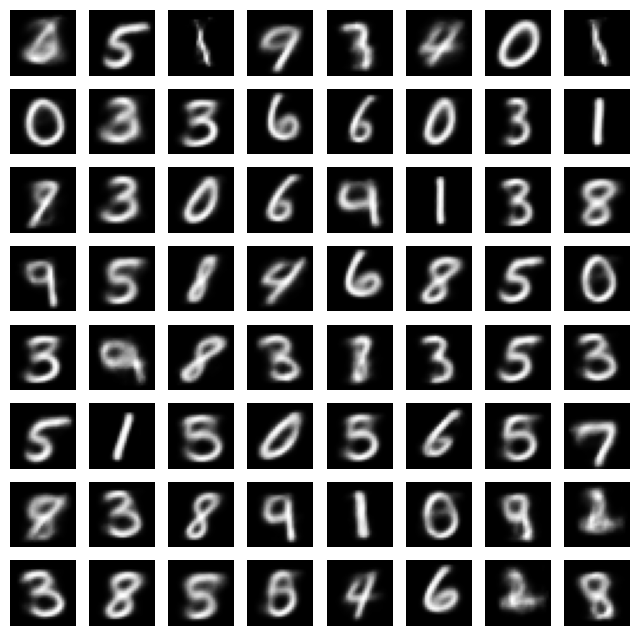

In [14]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('vae_mnist.webp')

In [15]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding'):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())

Encoding: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]


In [16]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

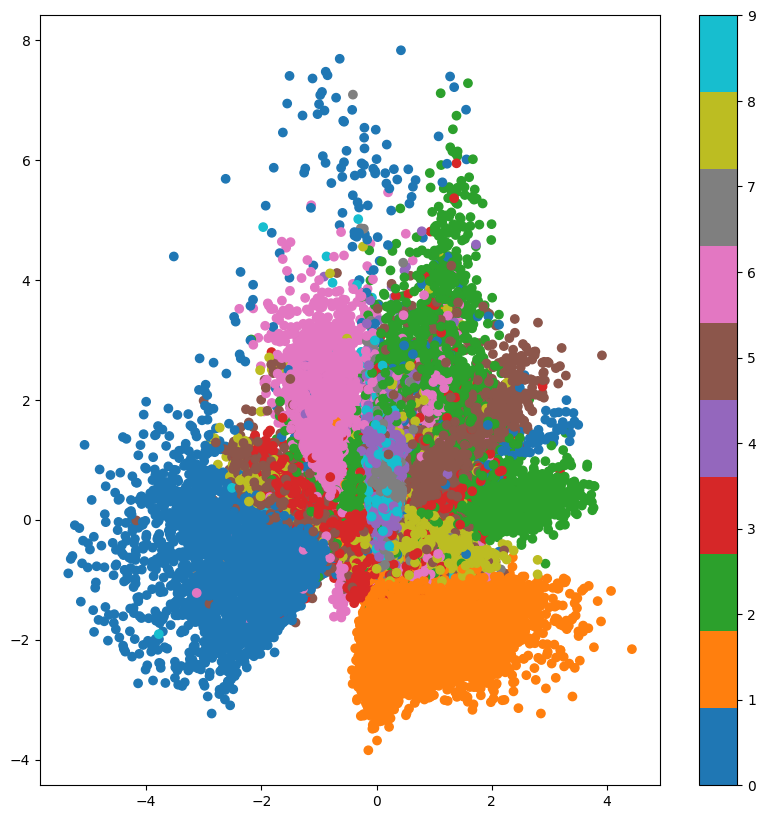

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

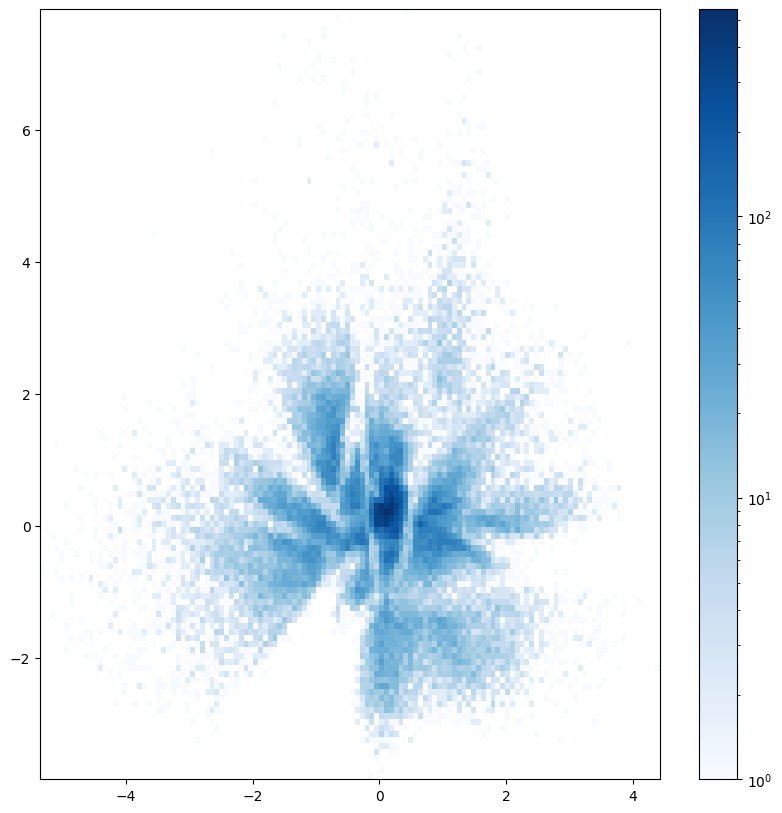

In [18]:

# plot as 2d histogram, log scale
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap='Blues', norm=LogNorm())
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_hist.webp')

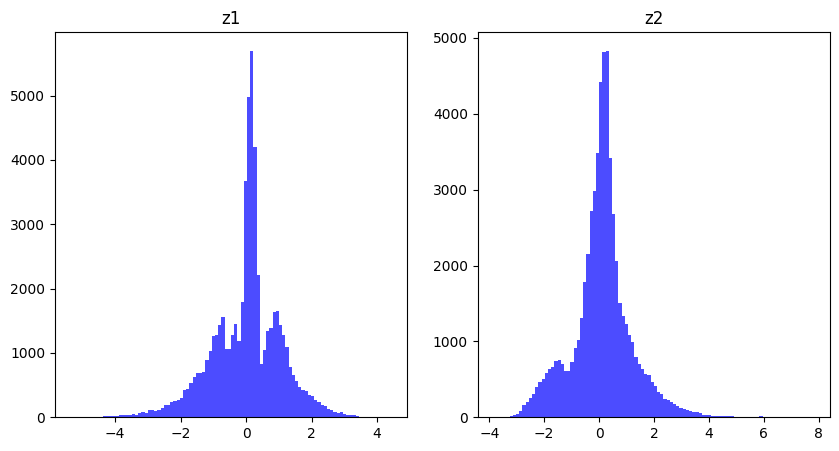

In [19]:
# plot 1d histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_all[:, 0], bins=100, color='b', alpha=0.7)
ax[0].set_title('z1')
ax[1].hist(z_all[:, 1], bins=100, color='b', alpha=0.7)
ax[1].set_title('z2')
# plt.show()
plt.savefig('vae_mnist_1d_hist.webp')

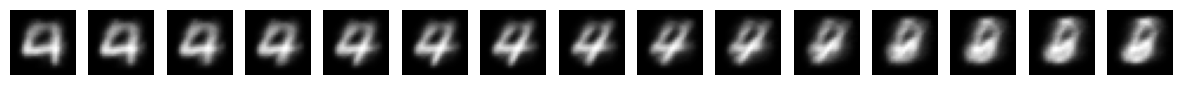

In [20]:
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('vae_mnist_interp.webp')